In [1]:
#%% relevant paths
figs='/storage/homefs/mf23m219/figs/SC_env/'
scr_data='/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/'
code='/home/mfeldmann/code/'
import sys, os
sys.path.append(code)
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
#from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage.morphology as skimo
from scipy.ndimage import convolve
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion
import copy
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from scipy.stats import combine_pvalues
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.colors as colors
from scipy.ndimage import binary_dilation
from skimage.morphology import disk

In [125]:
c_c = scr_data + 'present_t-0/*.nc'
c_c_files = sorted(glob(c_c))
rows_r=[]
rows_l=[]
for file in c_c_files:
    print(file)
    data = xr.open_dataset(file)

    mask = data.TOT_PREC<(5/12)
    buffered_mask = xr.DataArray(
        binary_erosion(mask, structure=np.expand_dims(disk(5),axis=0)),  # 3-pixel radius
        dims=mask.dims,
        coords=mask.coords
    )

    data2 = data.where(buffered_mask)
    if data.signature==1:
        a1=data2.sel(x=data.x>0,y=data.y>0).mean(dim=("x","y"))
    if data.signature==-1:
        a1=data2.sel(x=data.x>0,y=data.y<0).mean(dim=("x","y"))

    pval = data.pressure.values

    lclval = a1.LCL_ML
    for p in [925,850,700,600,500]:
        zval = a1.sel(pressure=p).FI/9.81
        if zval>=lclval: lcl_p = p; break
        else: lcl_p = -1

    row = {
        'filename': file,
        'LCL_ML': lclval,
        'p_LCL': lcl_p,
        'CAPE_MU': a1.CAPE_MU.values,
        'CAPE_ML': a1.CAPE_ML.values,
        'CIN_ML': a1.CIN_ML.values,
        'WMS': a1.WMAXSHEAR_MU.values,
        'U_925': a1.U.sel(pressure=925).values,
        'U_850': a1.U.sel(pressure=850).values,
        'U_700': a1.U.sel(pressure=700).values,
        'U_600': a1.U.sel(pressure=600).values,
        'U_500': a1.U.sel(pressure=500).values,
        'U_400': a1.U.sel(pressure=400).values,
        'U_300': a1.U.sel(pressure=300).values,
        'U_200': a1.U.sel(pressure=200).values,
        'V_925': a1.V.sel(pressure=925).values,
        'V_850': a1.V.sel(pressure=850).values,
        'V_700': a1.V.sel(pressure=700).values,
        'V_600': a1.V.sel(pressure=600).values,
        'V_500': a1.V.sel(pressure=500).values,
        'V_400': a1.V.sel(pressure=400).values,
        'V_300': a1.V.sel(pressure=300).values,
        'V_200': a1.V.sel(pressure=200).values,

    }

    if data.signature==1: rows_r.append(row)
    if data.signature==-1: rows_l.append(row)

df_r = pd.DataFrame(rows_r)
df_l = pd.DataFrame(rows_l)

df_r.to_csv('/storage/homefs/mf23m219/SC_env/'+'current_RM.csv')
df_l.to_csv('/storage/homefs/mf23m219/SC_env/'+'current_LM.csv')
    






/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104170010600.nc
/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104200026300.nc
/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104200044000.nc
/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104220021900.nc
/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104220044600.nc
/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104220074300.nc
/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104220074301.nc
/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104220079600.nc
/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_201104220079601.nc
/storage/workspaces/giub_met

In [126]:
df_r = pd.DataFrame(rows_r)
df_l = pd.DataFrame(rows_l)
print(len(df_r),len(df_l))

8209 1216


In [127]:
ucol_r = df_r[['U_925', 'U_850', 'U_700', 'U_600', 'U_500', 'U_400', 'U_300', 'U_200']]
vcol_r = df_r[['V_925', 'V_850', 'V_700', 'V_600', 'V_500', 'V_400', 'V_300', 'V_200']]
ucol_l = df_l[['U_925', 'U_850', 'U_700', 'U_600', 'U_500', 'U_400', 'U_300', 'U_200']]
vcol_l = df_l[['V_925', 'V_850', 'V_700', 'V_600', 'V_500', 'V_400', 'V_300', 'V_200']]

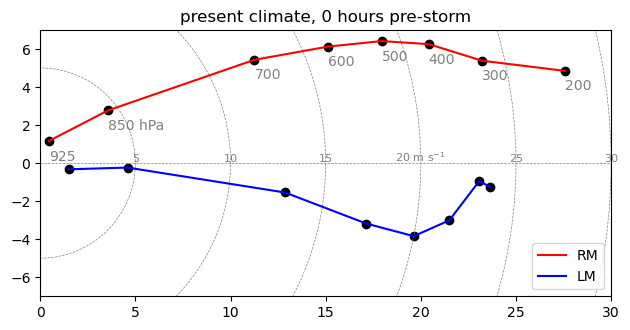

In [158]:
from matplotlib import patches
fig, ax = plt.subplots()
plt.title('present climate, 0 hours pre-storm')
ax.plot(np.nanmean(ucol_r,axis=0),np.nanmean(vcol_r,axis=0),c='r',label='RM')
ax.plot(np.nanmean(ucol_l,axis=0),np.nanmean(vcol_l,axis=0),c='b',label='LM')
ax.scatter(np.nanmean(ucol_r,axis=0),np.nanmean(vcol_r,axis=0),c='k')
x = np.nanmean(ucol_r,axis=0); y = np.nanmean(vcol_r,axis=0); text = ['925','850 hPa','700','600','500','400','300','200']
for i in range(len(x)):
    ax.text(x[i],y[i]-1,text[i],c='gray')
ax.scatter(np.nanmean(ucol_l,axis=0),np.nanmean(vcol_l,axis=0),c='k')
for r in [5, 10, 15, 20, 25, 30]:  # Radii of the circles
    circle = patches.Circle((0, 0), r, color='gray', fill=False, linestyle='--', linewidth=0.5)
    ax.add_patch(circle)
    if r ==20: ax.text(r, 0, str(r) + ' m s$^{-1}$', va='bottom', ha='center', fontsize=8, color='gray')
    else: ax.text(r, 0, str(r), va='bottom', ha='center', fontsize=8, color='gray')

# Make sure the aspect ratio is equal
ax.set_aspect('equal')
ax.set_ylim([-7,7])
ax.set_xlim([0,30])
ax.hlines(0,0,30,color='gray', linestyle='--', linewidth=0.5)
ax.legend()
plt.tight_layout()
plt.savefig(figs+'hodo_c_0.png',dpi=300)


In [124]:
np.nanmean(vcol_l,axis=0)

array([array([-0.04019856], dtype=float32),
       array([-0.48483276], dtype=float32),
       array([-2.1868265], dtype=float32),
       array([-3.5640042], dtype=float32),
       array([-4.0655427], dtype=float32),
       array([-2.6345983], dtype=float32),
       array([-0.5780227], dtype=float32),
       array([-1.4364324], dtype=float32)], dtype=object)

In [2]:
c_c = scr_data + 'present_t-0/*.nc'
c_c_files = glob(c_c)
print(c_c_files[7000])
data = xr.open_dataset(c_c_files[7000])
data

/storage/workspaces/giub_meteo_impacts/ci01/supercell_climate/cookies/present_t-0/cookie_202006280021301.nc


<xarray.Dataset> Size: 2MB
Dimensions:               (cookie_id: 1, x: 61, y: 61, pressure: 8)
Coordinates:
  * cookie_id             (cookie_id) int64 8B 202006280021301
  * pressure              (pressure) float32 32B 200.0 300.0 ... 850.0 925.0
  * x                     (x) float64 488B -66.0 -63.8 -61.6 ... 61.6 63.8 66.0
  * y                     (y) float64 488B -66.0 -63.8 -61.6 ... 61.6 63.8 66.0
Data variables: (12/90)
    U_10M                 (cookie_id, x, y) float32 15kB ...
    V_10M                 (cookie_id, x, y) float32 15kB ...
    VMAX_10M              (cookie_id, x, y) float32 15kB ...
    T_2M                  (cookie_id, x, y) float32 15kB ...
    TD_2M                 (cookie_id, x, y) float32 15kB ...
    RELHUM_2M             (cookie_id, x, y) float32 15kB ...
    ...                    ...
    cell_max_rain         (cookie_id) float32 4B ...
    cell_max_hail         (cookie_id) float32 4B ...
    real_time             (cookie_id) datetime64[ns] 8B ...
    t_rel_start           (cookie_id) timedelta64[ns] 8B ...
    t_rel_end             (cookie_id) timedelta64[ns] 8B ...
    itime                 (cookie_id) int64 8B ...
Attributes:
    title:                         COSMO driven by ERA5
    source:                        COSMO_5.08
    Conventions:                   CF-1.4
    conventionsURL:                http://www.cfconventions.org/
    creation_date:                 202406300211
    cookie_creator:                extract_environment.py
    cookie_creator_version:        0.2
    cookie_creator_version_date:   20240613
    cookie_creator_author:         Killian P. Brennan
    horizontal coordinate system:  x and y are relative to the mesocyclone ce...
    vertical coordinate system:    pressure levels are in hPa

In [6]:
np.unique(data.QV.values)

array([3.0590905e-05, 3.0668489e-05, 3.0844956e-05, ..., 1.5569020e-02,
       1.5737595e-02,           nan], dtype=float32)

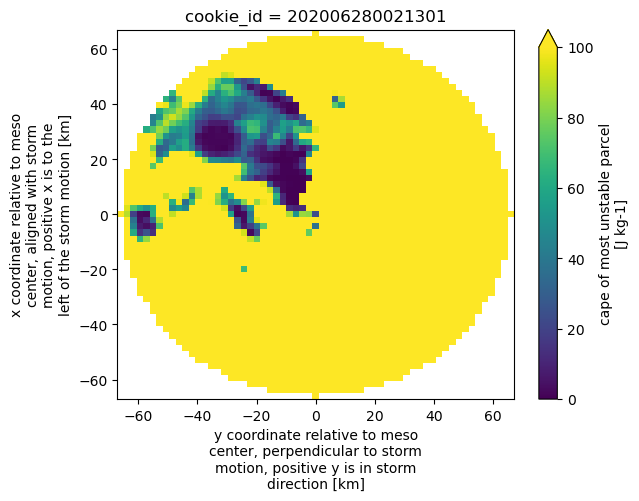

In [193]:
data.CAPE_MU.plot(vmin=0,vmax=100)

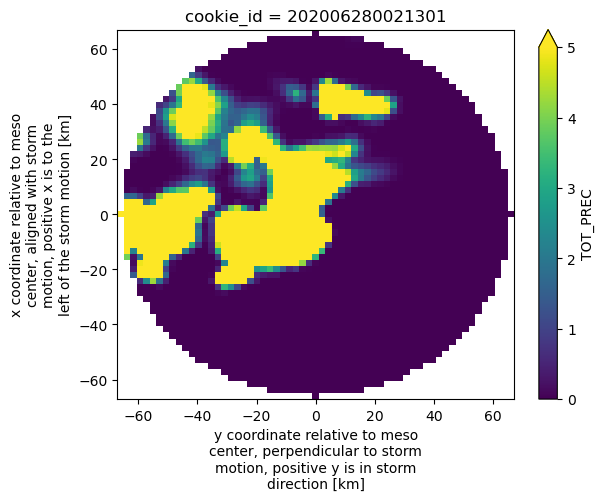

In [194]:
(data.TOT_PREC*12).plot(vmin=0,vmax=5)

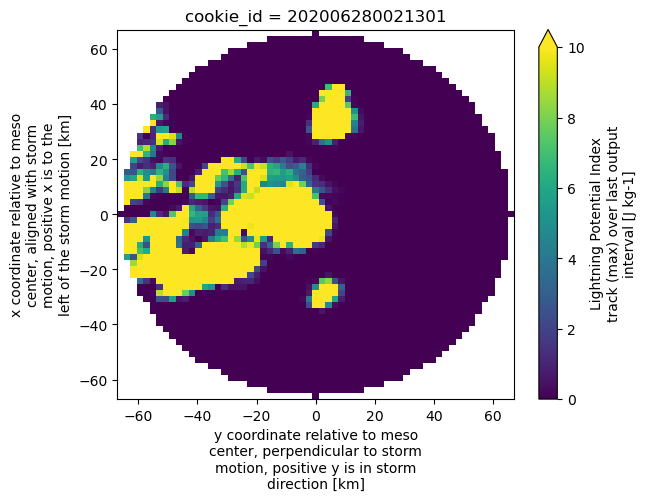

In [195]:
data.LPI_MAX.plot(vmin=0,vmax=10)

In [200]:

mask = data.TOT_PREC<(5/12)
buffered_mask = xr.DataArray(
    binary_erosion(mask, structure=np.expand_dims(disk(5),axis=0)),  # 3-pixel radius
    dims=mask.dims,
    coords=mask.coords
)

data2 = data.where(buffered_mask)
print(data.signature.values)
if data.signature==1:
    a1=data2.sel(x=data.x>0,y=data.y>0).mean(dim=("x","y"))
if data.signature==-1:
    a1=data2.sel(x=data.x>0,y=data.y<0).mean(dim=("x","y"))

[1]


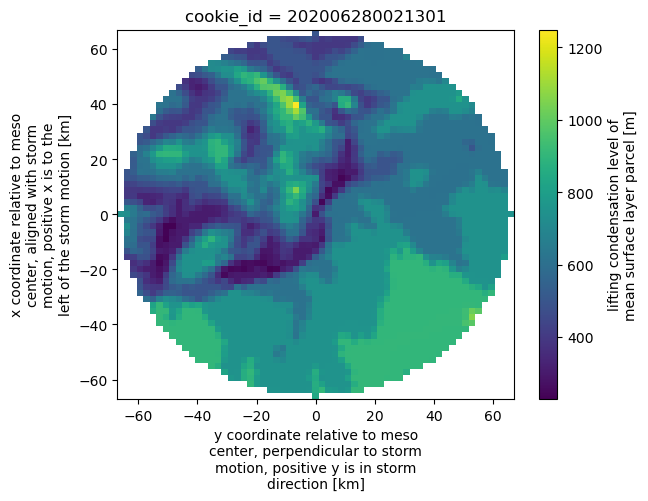

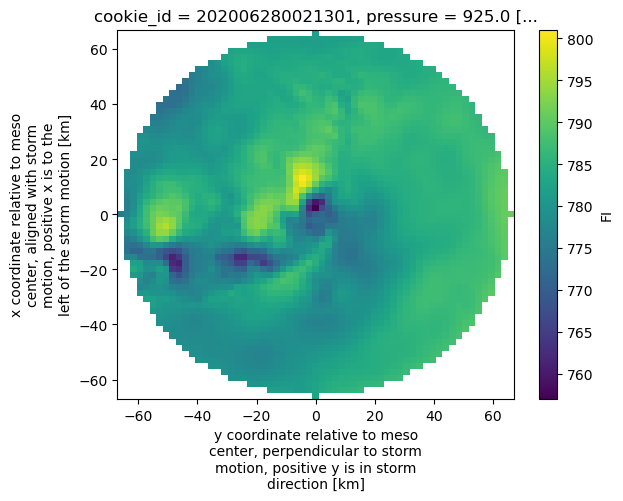

In [197]:
data.LCL_ML.plot()
plt.show()

(data.sel(pressure=925).FI/9.81).plot()
plt.show()

<xarray.DataArray 'pressure' (pressure: 8)> Size: 32B
array([200., 300., 400., 500., 600., 700., 850., 925.], dtype=float32)
Coordinates:
  * pressure  (pressure) float32 32B 200.0 300.0 400.0 ... 700.0 850.0 925.0
Attributes:
    units:        hPa
    long_name:    pressure
    positive:     down
    _metpy_axis:  vertical


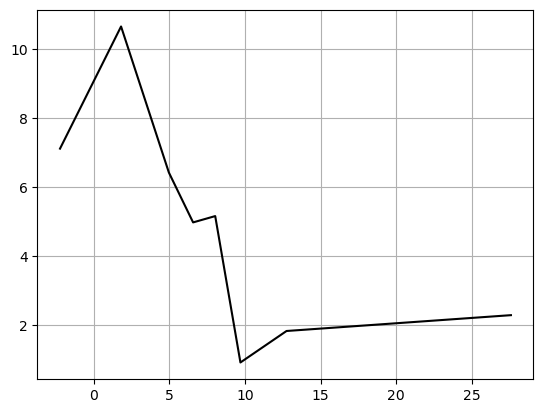

In [198]:
print(a1.pressure)
plt.plot(a1.U.squeeze(),a1.V.squeeze(),c='k')
plt.grid()
plt.show()

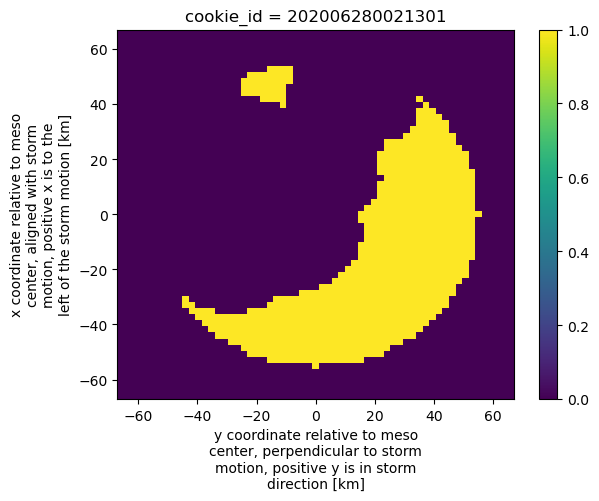

In [199]:
buffered_mask.plot()